In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [2]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from collections import Counter
import xgboost as xgb
from xgboost import plot_importance
from catboost import CatBoostRegressor
from textblob import TextBlob

import tensorflow as tf

import gensim.downloader
from gensim.models import Word2Vec
import nltk

In [3]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:23<00:00,  5.50it/s]


In [ ]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [6]:
prompts = []
characters_to_remove = ["\n","`",'\\']
code2prompts = defaultdict(list)
code2prompts_str = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
          for element in characters_to_remove: #Removal of such characters
            conv["text"] = conv["text"].replace(element,"")
          prompts.append(conv["text"])
          user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [7]:
questions = [ #Removed a question here wasn't leading to points also removed some characters!
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset and Preprocessing
Understanding the Dataset:
Find the shape of the dataset (number of samples and number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:
Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X and y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

""",
#####################
"""Tune Hyperparameters
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen in part 5).
Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained in step 6.
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks.
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split"""
#####################
]
for item in questions:
  for element in characters_to_remove: #Removal of such characters
    item = item.replace(element,"")


In [8]:
#Train A Word2Vec Model
nltk.download('punkt')

# Tokenize sentences and create a flat list of sentences
sentence_load = []
test_list = list(code2prompts.values())
test_list.append(questions)
for sentences in test_list:
    for sentence in sentences:
        # Tokenize each sentence
        tokenized_sentence = nltk.word_tokenize(sentence)
        sentence_load.append(tokenized_sentence)

# Training the Word2Vec model
vector_size = 600
window = 5
min_count = 2

hw_grading_word2vec_model = Word2Vec(
    sentences=sentence_load,
    vector_size=vector_size,
    window=window,
    min_count= min_count,
    workers=10
)
hw_grading_word2vec_model
#Train A Word2Vec Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
def vectorize_sentence(prompt): ## Each sentence of prompt being vectorized
  user_vector_list = list([])
  for sentence in prompt:
    tokens = sentence.split()
    word_vectors = [hw_grading_word2vec_model.wv[word] for word in tokens if word in hw_grading_word2vec_model.wv]
    if not word_vectors:
      user_vector_list.append(np.zeros(hw_grading_word2vec_model.vector_size))
      continue
    user_vector_list.append(np.mean(word_vectors, axis=0))
  return user_vector_list

code2prompts_word2vec = dict()
for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      print(code+".html")
      continue
  prompts_word2Vec = pd.DataFrame(vectorize_sentence(user_prompts))
  code2prompts_word2vec[code] = prompts_word2Vec

questions_word2Vec = pd.DataFrame(vectorize_sentence(questions)) #Questions vectorized


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
code2prompts_word2vec["7ac3f7a5-bdbb-470c-a1b3-03da5887a408"]

In [11]:
questions_word2Vec

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.289471,-0.125325,-0.145231,-0.058106,0.284374,0.082187,-0.113018,0.362512,0.030014,0.069381,...,-0.198277,-0.067954,-0.073007,-0.104904,0.119126,0.204679,0.123521,-0.186967,-0.177127,-0.198885
1,0.344080,-0.058450,-0.211639,-0.040345,0.332932,0.048467,0.024160,0.386330,0.082727,0.020877,...,-0.257716,-0.098356,-0.110280,-0.142375,0.187351,0.337807,0.062442,-0.224499,0.019791,-0.247123
2,0.200492,0.002868,-0.016313,-0.160514,0.262597,-0.014129,-0.041677,0.420578,-0.122961,0.135283,...,-0.301734,0.038989,-0.036744,0.057897,-0.002256,0.014491,0.026657,-0.179023,-0.098898,0.005534
3,0.206337,-0.054591,-0.070531,-0.197933,0.161873,0.067426,0.084800,0.404260,-0.172274,0.109946,...,-0.425051,-0.058073,-0.214646,-0.154029,0.068780,-0.033941,-0.100660,-0.191526,0.201716,-0.167335
4,0.395025,-0.099573,-0.272883,0.107570,0.204441,0.070304,0.083993,0.492213,-0.055549,-0.154631,...,-0.082770,-0.079241,-0.019361,-0.193702,0.240177,0.357334,0.018549,-0.139879,0.097814,-0.233687
5,0.333295,-0.088484,-0.392929,-0.040421,0.262605,0.192597,0.074793,0.554135,0.001806,-0.136849,...,-0.145551,0.035699,-0.112225,-0.171097,0.167017,0.326392,0.158712,-0.159184,-0.094404,-0.326528
6,0.350360,-0.093170,-0.187656,-0.016255,0.219065,0.021035,0.025009,0.504634,-0.026656,-0.049277,...,-0.123534,0.034463,0.010091,-0.117550,0.175636,0.245888,0.086506,-0.048336,-0.123063,-0.193879
7,0.413697,-0.279718,0.024425,-0.246213,0.291938,0.030493,-0.239213,0.704624,-0.013159,-0.025618,...,-0.463202,-0.116612,0.074507,-0.092683,0.255044,0.028331,0.030250,0.032051,-0.135178,-0.232179


In [12]:
code2cosine_word2vec = dict()
for code, user_prompts_word2vec in code2prompts_word2vec.items():
    code2cosine_word2vec[code] = pd.DataFrame(cosine_similarity(questions_word2Vec,user_prompts_word2vec))

In [13]:
code2questionmapping_word2vec = dict()
for code, cosine_scores in code2cosine_word2vec.items():
    code2questionmapping_word2vec[code] = code2cosine_word2vec[code].max(axis=1).tolist()


question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_word2vec #Similarity matrix between questions and prompts of user

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.948640,0.950162,0.886750,0.956801,0.936457,0.908444,0.926162,0.832502
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.954775,0.956330,0.987043,0.954638,0.999661,0.971893,0.928805,0.983796
2,041f950b-c013-409a-a642-cffff60b9d4b,0.939036,0.965178,0.785241,0.941434,0.891955,0.918927,0.962043,0.787962
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.864291,0.888858,0.859675,0.896490,0.928084,0.868841,0.920568,0.964335
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.944045,0.950368,0.957888,0.952967,0.987073,0.968036,0.990835,0.975801
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.925876,0.940442,0.837594,0.900534,0.922058,0.999163,0.998553,0.987879
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.903463,0.943779,0.996831,0.992126,0.991342,0.939841,0.993039,0.970461
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.981728,0.999359,0.996389,0.999497,0.999461,0.998369,0.999178,0.979463
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.977375,0.993727,0.955148,0.999678,0.986216,1.000000,1.000000,0.942814


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [14]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "next", "Entropy","how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
  if len(convs) == 0:
      print(code)
      continue
  for c in convs:
    text = c["text"].lower()
    if c["role"] == "user":
        # User Prompts

        # count the user prompts
        code2features[code]["#user_prompts"] += 1

        # count the keywords
        for kw in keywords2search:
            code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

        code2features[code]["prompt_avg_chars"] += len(text)

        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        blob = TextBlob(text)
        code2features[code]["unique_avg_chars"] += len(words)
        code2features[code]["sentiment_point"] += blob.sentiment.polarity

    else:
        # ChatGPT Responses
        code2features[code]["response_avg_chars"] += len(text)
        code2features[code]["response_unique_avg_chars"] += len(words)

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["unique_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["sentiment_point"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_unique_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [15]:
df_word2vec = pd.DataFrame(code2features).T
df_word2vec

,#user_prompts,#error,#no,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488
...,...,...,...,...,...,...,...,...,...,...,...
f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,0.0,4.0,2.0,0.118153,0.018192,5.887080e-28,131.912683,0.381975
f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,1.0,6.0,17.0,0.117639,0.008531,2.315368e-05,8.186395,0.605679
f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,4.0,3.0,4.0,0.104486,0.023343,5.617300e-11,82.654365,0.700269
f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,1.0,3.0,3.0,0.124045,0.031561,3.564049e-06,201.260014,0.440895


In [16]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


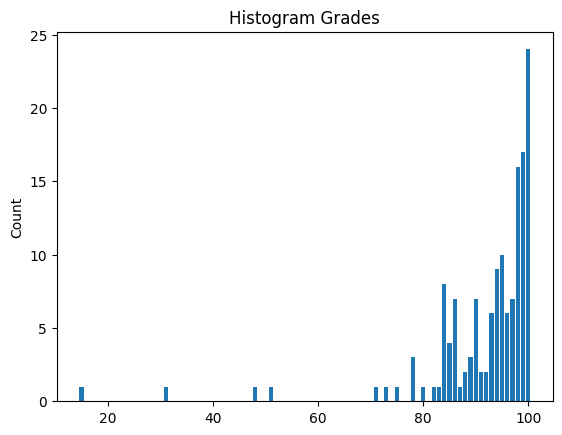

In [17]:
#Grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [18]:
df_word2vec.reset_index(inplace=True, drop=False)
df_word2vec.rename(columns={"index": "code"}, inplace=True)

df_word2vec.head()

,code,#user_prompts,#error,#no,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488


In [19]:
df_word2vec = pd.merge(df_word2vec, question_mapping_scores_word2vec, on="code", how="left")
df_word2vec.head()

,code,#user_prompts,#error,#no,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444,0.948640,0.950162,0.886750,0.956801,0.936457,0.908444,0.926162,0.832502
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644,0.954775,0.956330,0.987043,0.954638,0.999661,0.971893,0.928805,0.983796
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228,0.939036,0.965178,0.785241,0.941434,0.891955,0.918927,0.962043,0.787962
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239,0.864291,0.888858,0.859675,0.896490,0.928084,0.868841,0.920568,0.964335
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488,0.944045,0.950368,0.957888,0.952967,0.987073,0.968036,0.990835,0.975801


#### Merging scores with features

In [20]:
temp_df_word2vec = pd.merge(df_word2vec, scores, on='code', how="left")
temp_df_word2vec.dropna(inplace=True)
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")

temp_df_word2vec.head()

,code,#user_prompts,#error,#no,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,...,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,...,4.515444,0.948640,0.950162,0.886750,0.956801,0.936457,0.908444,0.926162,0.832502,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,...,1.003644,0.954775,0.956330,0.987043,0.954638,0.999661,0.971893,0.928805,0.983796,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,...,0.466228,0.939036,0.965178,0.785241,0.941434,0.891955,0.918927,0.962043,0.787962,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,...,0.352239,0.864291,0.888858,0.859675,0.896490,0.928084,0.868841,0.920568,0.964335,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,...,0.267488,0.944045,0.950368,0.957888,0.952967,0.987073,0.968036,0.990835,0.975801,100.0


In [21]:
X_word2vec = temp_df_word2vec[temp_df_word2vec.columns[1:-1]].to_numpy()
y_word2vec = temp_df_word2vec["grade"].to_numpy()

print(X_word2vec.shape, y_word2vec.shape)

(122, 19) (122,)


#### Train/Test split

In [22]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_word2vec))
print("Test set size:", len(X_test_word2vec))

Train set size: 97
Test set size: 25


#Fitting a model

## Predicting and Analyzing

###Word2vec Decision Tree Regressor Model Implementation

In [23]:
#Initial word2vec Decision Tree Regressor Model
model_word2vec_init = DecisionTreeRegressor(criterion='squared_error', random_state=42)
model_word2vec_init.fit(X_train_word2vec, y_train_word2vec)
# word2vec Decision Tree Regressor Model evaluation
y_pred_word2vec_init_test = model_word2vec_init.predict(X_test_word2vec)

#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init_test)):
  if y_pred_word2vec_init_test[index] < 0:
    y_pred_word2vec_init_test[index] = 0
  elif y_pred_word2vec_init_test[index] > 100:
    y_pred_word2vec_init_test[index] = 100

#Test Results
mae_word2vec_init_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init_test)
mse_word2vec_init_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init_test)
rmse_word2vec_init_test = np.sqrt(mse_word2vec_init_test)
r2_word2vec_init_test = r2_score(y_test_word2vec, y_pred_word2vec_init_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init_test}")
print(f"R-squared Test: {r2_word2vec_init_test}")
print(f"Predicted values for testing:{y_pred_word2vec_init_test}")

#Train Results
y_pred_word2vec_init_train = model_word2vec_init.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init_train)):
  if y_pred_word2vec_init_train[index] < 0:
    y_pred_word2vec_init_train[index] = 0
  elif y_pred_word2vec_init_train[index] > 100:
    y_pred_word2vec_init_train[index] = 100

mae_word2vec_init_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init_train)
mse_word2vec_init_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init_train)
rmse_word2vec_init_train = np.sqrt(mse_word2vec_init_train)
r2_word2vec_init_train = r2_score(y_train_word2vec, y_pred_word2vec_init_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init_train}")
print(f"R-squared Train: {r2_word2vec_init_train}")
print(f"Predicted values for training:{y_pred_word2vec_init_train}")

Mean Absolute Error (MAE) Test: 5.96
Mean Squared Error (MSE) Test: 69.56
Root Mean Squared Error (RMSE) Test: 8.340263784797218
R-squared Test: 0.38039791351936836
Predicted values for testing:[ 98.  71.  99.  95.  95.  99. 100. 100. 100.  99.  85.  98.  93.  92.
 100.  92.  98.  94.  94.  71.  89.  95. 100.  94.  85.]
<---------->
Mean Absolute Error (MAE) Train: 0.0
Mean Squared Error (MSE) Train: 0.0
Root Mean Squared Error (RMSE) Train: 0.0
R-squared Train: 1.0
Predicted values for training:[100.  51.  96.  94. 100.  84. 100.  94.  97.  85.  98.  90.  88.  99.
  99.  83.  98.  99.  86. 100. 100.  89.  84.  99. 100. 100.  75.  98.
 100.  97.  95.  95.  80. 100.  95.  99.  99.  93.  98.  90.  82.  89.
  97.  99.  97. 100.  84.  93.  96.  99.  96. 100.  99.  86.  91. 100.
  95.  85. 100. 100.  94.  96.  89.  31.  85.  93.  78.  94.  71.  15.
  93.  73.  94.  84.  98.  98.  99.  99. 100.  90. 100.  92.  90.  95.
 100.  95.  93.  98.  98.  95.  90.  86.  96.  99.  99.  84.  92.]


In [24]:
#Cross validation check for all min_samples_split values
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model to be cross validated
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)


  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

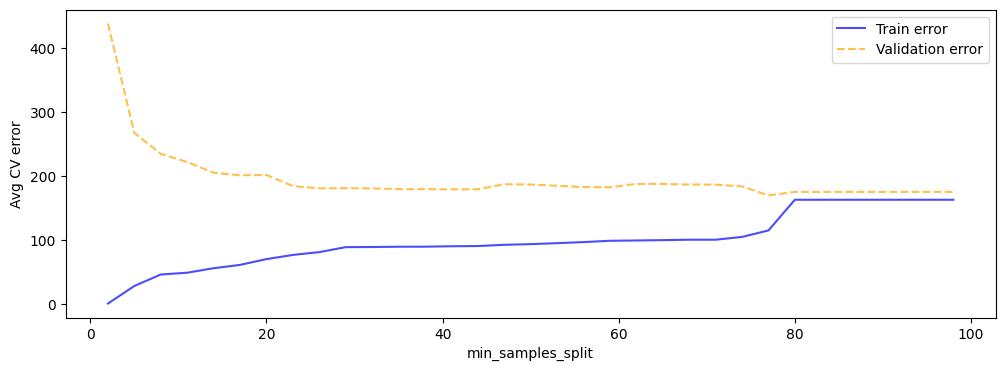

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [26]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

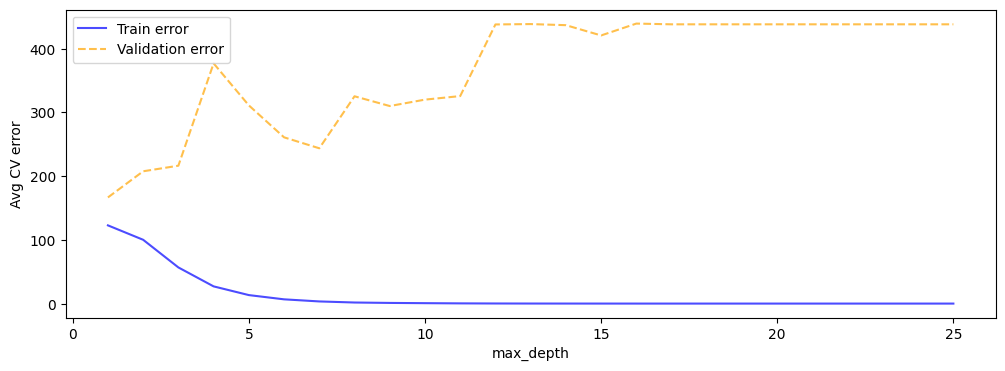

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [28]:
#Hyper parameter search space
param_grid = {
    'max_depth': [i for i in range(6,15)],
    'min_samples_split': [j for j in range(60,75)]
}

estimator = DecisionTreeRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_decision_tree_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_decision_tree_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74]},
             scoring='neg_mean_squared_error')

In [29]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results_decision_tree = pd.DataFrame(grid_search_decision_tree_tune.cv_results_)[cols_to_include]
results_decision_tree.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,6,60,-181.973257,195.801372
90,12,60,-181.973257,195.801372
30,8,60,-181.973257,195.801372
45,9,60,-181.973257,195.801372
60,10,60,-181.973257,195.801372
...,...,...,...,...
107,13,62,-187.229286,206.065164
106,13,61,-187.229286,206.065164
48,9,63,-187.229286,206.065164
1,6,61,-187.229286,206.065164


In [30]:
#Use parameters that were the best from previous part
model_word2vec_tuned = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_decision_tree_tune.best_params_['max_depth'],
    min_samples_split=grid_search_decision_tree_tune.best_params_['min_samples_split']
)

model_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned_test = model_word2vec_tuned.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned_test)):
  if y_pred_word2vec_tuned_test[index] < 0:
    y_pred_word2vec_tuned_test[index] = 0
  elif y_pred_word2vec_tuned_test[index] > 100:
    y_pred_word2vec_tuned_test[index] = 100


mae_word2vec_tuned_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned_test)
mse_word2vec_tuned_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned_test)
rmse_word2vec_tuned_test = np.sqrt(mse_word2vec_tuned_test)
r2_word2vec_tuned_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned_test}")
print(f"R-squared Test: {r2_word2vec_tuned_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned_test}")
#Train Results
y_pred_word2vec_tuned_train = model_word2vec_init.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned_train)):
  if y_pred_word2vec_tuned_train[index] < 0:
    y_pred_word2vec_tuned_train[index] = 0
  elif y_pred_word2vec_tuned_train[index] > 100:
    y_pred_word2vec_tuned_train[index] = 100

mae_word2vec_tuned_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned_train)
mse_word2vec_tuned_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned_train)
rmse_word2vec_tuned_train = np.sqrt(mse_word2vec_tuned_train)
r2_word2vec_tuned_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned_train}")
print(f"R-squared Train: {r2_word2vec_tuned_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned_train}")

Mean Absolute Error (MAE) Test: 6.010098870056497
Mean Squared Error (MSE) Test: 97.49985104156694
Root Mean Squared Error (RMSE) Test: 9.874201286259408
R-squared Test: 0.13152514179261543
Predicted values for testing: [96.10169492 86.4375     96.10169492 96.10169492 96.10169492 96.10169492
 96.10169492 96.10169492 96.10169492 86.4375     85.33333333 96.10169492
 96.10169492 96.10169492 96.10169492 96.10169492 96.10169492 96.10169492
 96.10169492 86.4375     96.10169492 96.10169492 86.4375     96.10169492
 86.4375    ]
<---------->
Mean Absolute Error (MAE) Train: 0.0
Mean Squared Error (MSE) Train: 0.0
Root Mean Squared Error (RMSE) Train: 0.0
R-squared Train: 1.0
Predicted values for training: [100.  51.  96.  94. 100.  84. 100.  94.  97.  85.  98.  90.  88.  99.
  99.  83.  98.  99.  86. 100. 100.  89.  84.  99. 100. 100.  75.  98.
 100.  97.  95.  95.  80. 100.  95.  99.  99.  93.  98.  90.  82.  89.
  97.  99.  97. 100.  84.  93.  96.  99.  96. 100.  99.  86.  91. 100.
  95.  85.

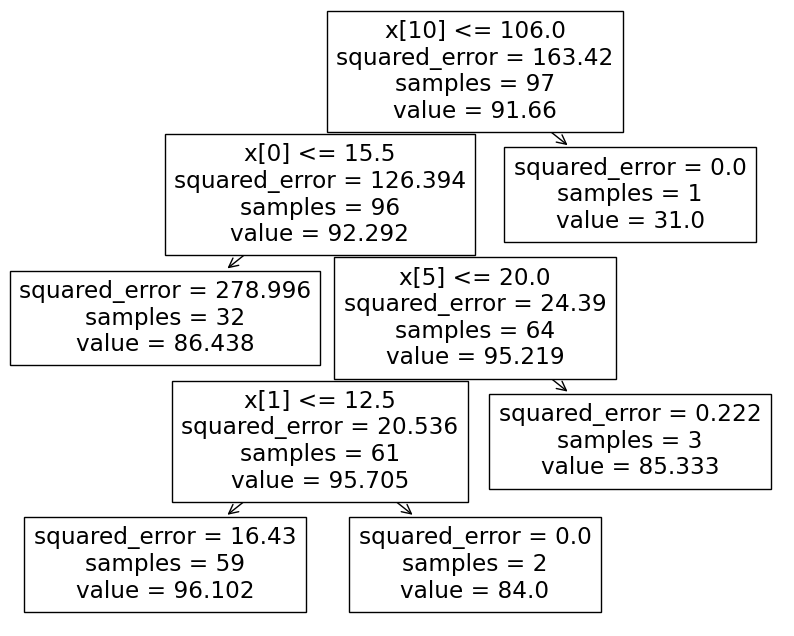

In [31]:
plt.figure(figsize=(10, 8))
plot_tree(model_word2vec_tuned)
plt.show()

###Word2vec Random Forest Regressor Model Implementation

In [32]:
#Random Forest Regressor Model
model_word2vec_init1 = RandomForestRegressor(
  criterion='squared_error',
  random_state=42)

model_word2vec_init1.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init1_test = model_word2vec_init1.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init1_test)):
  if y_pred_word2vec_init1_test[index] < 0:
    y_pred_word2vec_init1_test[index] = 0
  elif y_pred_word2vec_init1_test[index] > 100:
    y_pred_word2vec_init1_test[index] = 100

mae_word2vec_init1_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init1_test)
mse_word2vec_init1_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init1_test)
rmse_word2vec_init1_test = np.sqrt(mse_word2vec_init1_test)
r2_word2vec_init1_test = r2_score(y_test_word2vec, y_pred_word2vec_init1_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init1_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init1_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init1_test}")
print(f"R-squared Test: {r2_word2vec_init1_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init1_test}")

#Train Results
y_pred_word2vec_init1_train = model_word2vec_init1.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init1_train)):
  if y_pred_word2vec_init1_train[index] < 0:
    y_pred_word2vec_init1_train[index] = 0
  elif y_pred_word2vec_init1_train[index] > 100:
    y_pred_word2vec_init1_train[index] = 100

mae_word2vec_init1_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init1_train)
mse_word2vec_init1_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init1_train)
rmse_word2vec_init1_train = np.sqrt(mse_word2vec_init1_train)
r2_word2vec_init1_train = r2_score(y_train_word2vec, y_pred_word2vec_init1_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init1_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init1_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init1_train}")
print(f"R-squared Train: {r2_word2vec_init1_train}")
print(f"Predicted values for training: {y_pred_word2vec_init1_train}")

Mean Absolute Error (MAE) Test: 6.2632
Mean Squared Error (MSE) Test: 101.68072800000002
Root Mean Squared Error (RMSE) Test: 10.083686230739234
R-squared Test: 0.09428419747456018
Predicted values for testing: [95.59 90.18 90.5  90.83 90.63 95.31 97.92 93.05 98.25 92.18 91.87 93.37
 95.77 94.9  95.04 94.21 96.58 93.97 94.69 89.12 81.73 94.68 93.05 94.16
 89.22]
<---------->
Mean Absolute Error (MAE) Train: 2.897835051546391
Mean Squared Error (MSE) Train: 25.652904123711334
Root Mean Squared Error (RMSE) Train: 5.0648696057955265
R-squared Train: 0.8430250250711814
Predicted values for training: [97.93 66.7  95.33 90.8  98.57 86.21 97.84 95.51 96.2  87.66 97.71 88.72
 88.83 97.23 97.09 86.66 96.03 96.37 85.86 96.39 89.   90.71 87.83 92.51
 96.5  96.36 80.18 97.56 98.19 97.43 92.48 93.41 85.86 98.2  91.07 95.19
 97.09 93.8  95.2  90.4  85.51 91.24 93.98 97.01 96.25 95.84 86.98 93.11
 93.43 98.72 96.33 97.38 97.7  90.62 92.52 96.99 91.27 87.62 98.08 96.29
 92.9  96.36 90.53 55.21 86.5  

In [33]:
#Cross Validation for min_samples_split of the tree
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

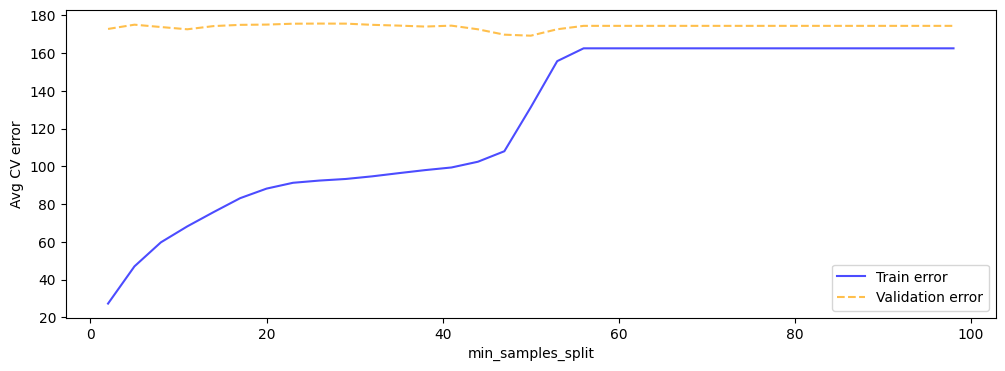

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [35]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

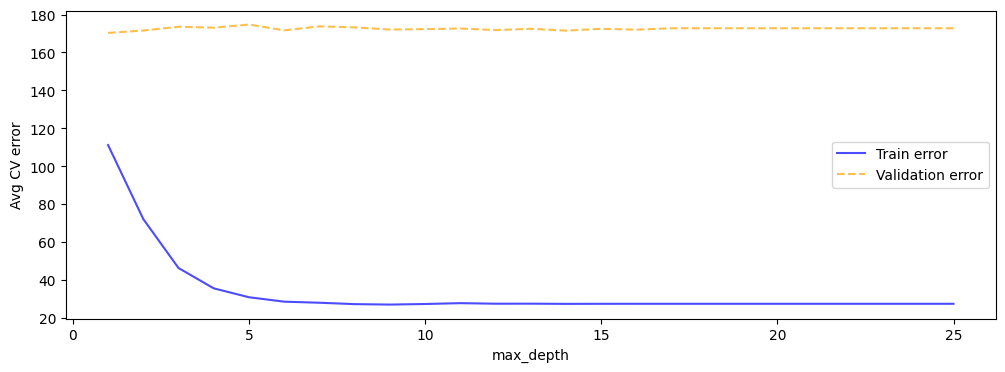

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [37]:
param_grid = {
    'max_depth': [i for i in range(10,18)],
    'min_samples_split': [j for j in range(40,62)],
}

estimator = RandomForestRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_randomforest_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_randomforest_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17],
                         'min_samples_split': [40, 41, 42, 43, 44, 45, 46, 47,
                                               48, 49, 50, 51, 52, 53, 54, 55,
                                               56, 57, 58, 59, 60, 61]},
             scoring='neg_mean_squared_error')

In [38]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_randomforest_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
163,17,49,-167.025888,208.081702
97,14,49,-167.025888,208.081702
53,12,49,-167.025888,208.081702
141,16,49,-167.025888,208.081702
9,10,49,-167.025888,208.081702
...,...,...,...,...
112,15,42,-174.762908,197.540589
24,11,42,-174.762908,197.540589
68,13,42,-174.762908,197.540589
46,12,42,-174.762908,197.540589


In [57]:
model_word2vec_tuned1 = RandomForestRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_randomforest_tune.best_params_['max_depth'],
    min_samples_split=grid_search_randomforest_tune.best_params_['min_samples_split'],
    n_estimators = 1000
)
model_word2vec_tuned1.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned1_test = model_word2vec_tuned1.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned1_test)):
  if y_pred_word2vec_tuned1_test[index] < 0:
    y_pred_word2vec_tuned1_test[index] = 0
  elif y_pred_word2vec_tuned1_test[index] > 100:
    y_pred_word2vec_tuned1_test[index] = 100

mae_word2vec_tuned1_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned1_test)
mse_word2vec_tuned1_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned1_test)
rmse_word2vec_tuned1_test = np.sqrt(mse_word2vec_tuned1_test)
r2_word2vec_tuned1_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned1_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned1_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned1_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned1_test}")
print(f"R-squared Test: {r2_word2vec_tuned1_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned1_test}")
#Train Results
y_pred_word2vec_tuned1_train = model_word2vec_tuned1.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned1_train)):
  if y_pred_word2vec_tuned1_train[index] < 0:
    y_pred_word2vec_tuned1_train[index] = 0
  elif y_pred_word2vec_tuned1_train[index] > 100:
    y_pred_word2vec_tuned1_train[index] = 100

mae_word2vec_tuned1_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned1_train)
mse_word2vec_tuned1_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned1_train)
rmse_word2vec_tuned1_train = np.sqrt(mse_word2vec_init1_train)
r2_word2vec_tuned1_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned1_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned1_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned1_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned1_train}")
print(f"R-squared Train: {r2_word2vec_tuned1_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned1_train}")


Mean Absolute Error (MAE) Test: 6.632869780921113
Mean Squared Error (MSE) Test: 101.33426044363887
Root Mean Squared Error (RMSE) Test: 10.066491963123939
R-squared Test: 0.09737033923446836
Predicted values for testing: [93.84927163 86.92432374 86.19764422 92.68325161 94.88510951 94.17712183
 95.42410833 94.27951843 95.49689879 83.32114745 94.83651254 85.95201835
 95.41683539 94.36880693 95.38431087 94.54406586 94.5531357  94.37823961
 92.90514705 86.55983821 85.69629476 94.86453477 88.37108955 95.2381231
 92.51175968]
<---------->
Mean Absolute Error (MAE) Train: 6.214534100128497
Mean Squared Error (MSE) Train: 102.30587589622259
Root Mean Squared Error (RMSE) Train: 5.0648696057955265
R-squared Train: 0.3739709848665289
Predicted values for training: [95.22675417 87.09186068 95.13198348 86.92365207 95.19645407 85.82686248
 95.02506892 95.46434596 94.83593882 94.31018544 95.56614143 85.85684695
 87.16199247 94.33875145 94.72743787 90.62707154 94.39378748 93.45217889
 87.21628951 92

###Word2vec Gradient Boosting Regressor Model Implementation

In [41]:
model_word2vec_init2 = GradientBoostingRegressor(criterion = 'squared_error',learning_rate=0.1, random_state=42)
model_word2vec_init2.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init2_test = model_word2vec_init2.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init2_test)):
  if y_pred_word2vec_init2_test[index] < 0:
    y_pred_word2vec_init2_test[index] = 0
  elif y_pred_word2vec_init2_test[index] > 100:
    y_pred_word2vec_init2_test[index] = 100

mae_word2vec_init2_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init2_test)
mse_word2vec_init2_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init2_test)
rmse_word2vec_init2_test = np.sqrt(mse_word2vec_init2_test)
r2_word2vec_init2_test = r2_score(y_test_word2vec, y_pred_word2vec_init2_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init2_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init2_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init2_test}")
print(f"R-squared Test: {r2_word2vec_init2_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init2_test}")

#Train Results
y_pred_word2vec_init2_train = model_word2vec_init2.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init2_train)):
  if y_pred_word2vec_init2_train[index] < 0:
    y_pred_word2vec_init2_train[index] = 0
  elif y_pred_word2vec_init2_train[index] > 100:
    y_pred_word2vec_init2_train[index] = 100

mae_word2vec_init2_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init2_train)
mse_word2vec_init2_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init2_train)
rmse_word2vec_init2_train = np.sqrt(mse_word2vec_init2_train)
r2_word2vec_init2_train = r2_score(y_train_word2vec, y_pred_word2vec_init2_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init2_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init2_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init2_train}")
print(f"R-squared Train: {r2_word2vec_init2_train}")
print(f"Predicted values for training: {y_pred_word2vec_init2_train}")

Mean Absolute Error (MAE) Test: 5.852481020160148
Mean Squared Error (MSE) Test: 71.87113363232473
Root Mean Squared Error (RMSE) Test: 8.477684449914653
R-squared Test: 0.35981161074875356
Predicted values for testing: [100.          90.28330939  92.27146559  98.05715653  91.07625979
  98.21308766  99.19939631  93.61893572  98.54230046  97.36327667
  92.03993882  98.54125486  96.60835624  95.0171059   97.87555762
  95.74896134  99.93252395  96.36173994  95.08378026  76.35035741
  92.79414127  95.87849862  96.0880511   93.55820075  89.27087835]
<---------->
Mean Absolute Error (MAE) Train: 1.0658850295137996
Mean Squared Error (MSE) Train: 1.6935632907568106
Root Mean Squared Error (RMSE) Train: 1.301369774797621
R-squared Train: 0.9896367657312846
Predicted values for training: [99.58728247 54.03560777 96.76997856 94.23491921 98.47913892 84.88090016
 99.06702936 95.55589818 97.15513662 86.07391009 98.20297202 90.25845732
 89.04827824 97.35048248 99.10384387 85.4383314  98.39743746 96.

In [42]:
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)


  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

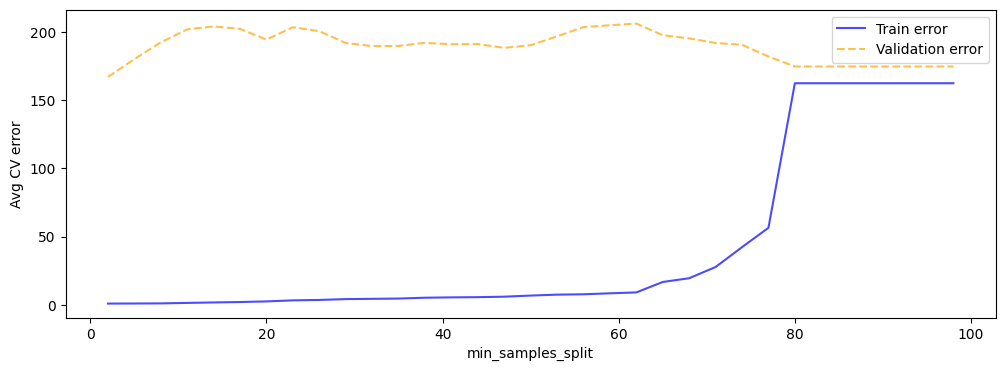

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [44]:
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

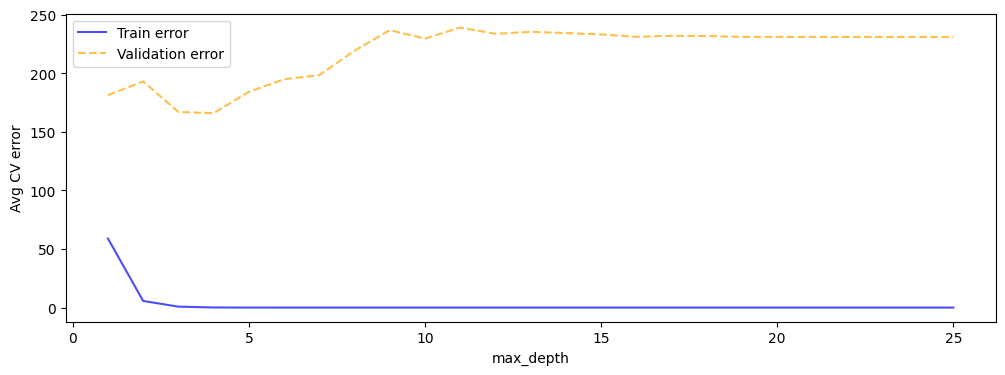

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [46]:
param_grid = {
    'max_depth': [i for i in range(3,16)],
    'min_samples_split': [j for j in range(60,81)]
}

estimator = GradientBoostingRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_gradient_boosting_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_gradient_boosting_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(criterion='squared_error',
                                                 random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74, 75,
                                               76, 77, 78, 79, 80]},
             scoring='neg_mean_squared_error')

In [47]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_gradient_boosting_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
249,14,78,-171.463360,222.107460
60,5,78,-171.463360,222.107460
207,12,78,-171.463360,222.107460
102,7,78,-171.463360,222.107460
228,13,78,-171.463360,222.107460
...,...,...,...,...
254,15,62,-208.728696,208.369926
191,12,62,-208.728696,208.369926
212,13,62,-208.728696,208.369926
170,11,62,-208.728696,208.369926


In [48]:
model_word2vec_tuned2 = GradientBoostingRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_gradient_boosting_tune.best_params_['max_depth'],
    min_samples_split=grid_search_gradient_boosting_tune.best_params_['min_samples_split'],
    n_estimators = 1000
)
model_word2vec_tuned2.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned2_test = model_word2vec_tuned2.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned2_test)):
  if y_pred_word2vec_tuned2_test[index] < 0:
    y_pred_word2vec_tuned2_test[index] = 0
  elif y_pred_word2vec_tuned2_test[index] > 100:
    y_pred_word2vec_tuned2_test[index] = 100

mae_word2vec_tuned2_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned2_test)
mse_word2vec_tuned2_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned2_test)
rmse_word2vec_tuned2_test = np.sqrt(mse_word2vec_tuned2_test)
r2_word2vec_tuned2_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned2_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned2_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned2_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned2_test}")
print(f"R-squared Test: {r2_word2vec_tuned2_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned2_test}")
#Train Results
y_pred_word2vec_tuned2_train = model_word2vec_tuned2.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned2_train)):
  if y_pred_word2vec_tuned2_train[index] < 0:
    y_pred_word2vec_tuned2_train[index] = 0
  elif y_pred_word2vec_tuned2_train[index] > 100:
    y_pred_word2vec_tuned2_train[index] = 100

mae_word2vec_tuned2_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned2_train)
mse_word2vec_tuned2_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned2_train)
rmse_word2vec_tuned2_train = np.sqrt(mse_word2vec_tuned2_train)
r2_word2vec_tuned2_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned2_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned2_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned2_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned2_train}")
print(f"R-squared Train: {r2_word2vec_tuned2_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned2_train}")

Mean Absolute Error (MAE) Test: 7.331696356055473
Mean Squared Error (MSE) Test: 130.99408980409203
Root Mean Squared Error (RMSE) Test: 11.445264951240405
R-squared Test: -0.16682305001792197
Predicted values for testing: [100.          78.33659293  77.80615882  94.69836812  91.90973635
 100.          98.31335491  91.59937702  98.32870289  98.97508272
  95.7590933   98.30326543  99.59216887  92.80629377 100.
  97.7044997  100.          95.97272419  93.1549883   91.05190574
  88.55733255 100.          97.44862436  95.09920143  86.74452308]
<---------->
Mean Absolute Error (MAE) Train: 0.3256405979367637
Mean Squared Error (MSE) Train: 0.19741185430461217
Root Mean Squared Error (RMSE) Train: 0.44431053814265103
R-squared Train: 0.998791999504981
Predicted values for training: [ 99.73055004  51.84550379  96.01463633  93.78783911  99.67919395
  83.92906794  99.85512612  94.34559452  97.14495485  85.16403678
  97.95427069  89.85341005  87.79573609  98.50519157  99.4087347
  84.15620162  9

###Word2vec XGBoost Regressor Model Implementation

In [49]:
model_word2vec_init3 = xgb.XGBRegressor()
model_word2vec_init3.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init3_test = model_word2vec_init3.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init3_test)):
  if y_pred_word2vec_init3_test[index] < 0:
    y_pred_word2vec_init3_test[index] = 0
  elif y_pred_word2vec_init3_test[index] > 100:
    y_pred_word2vec_init3_test[index] = 100


mae_word2vec_init3_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init3_test)
mse_word2vec_init3_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init3_test)
rmse_word2vec_init3_test = np.sqrt(mse_word2vec_init3_test)
r2_word2vec_init3_test = r2_score(y_test_word2vec, y_pred_word2vec_init3_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init3_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init3_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init3_test}")
print(f"R-squared Test: {r2_word2vec_init3_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init3_test}")
#Train Results
y_pred_word2vec_init3_train = model_word2vec_init3.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init3_train)):
  if y_pred_word2vec_init3_train[index] < 0:
    y_pred_word2vec_init3_train[index] = 0
  elif y_pred_word2vec_init3_train[index] > 100:
    y_pred_word2vec_init3_train[index] = 100


mae_word2vec_init3_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init3_train)
mse_word2vec_init3_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init3_train)
rmse_word2vec_init3_train = np.sqrt(mse_word2vec_init3_train)
r2_word2vec_init3_train = r2_score(y_train_word2vec, y_pred_word2vec_init3_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init3_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init3_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init3_train}")
print(f"R-squared Train: {r2_word2vec_init3_train}")
print(f"Predicted values for training: {y_pred_word2vec_init3_train}")

Mean Absolute Error (MAE) Test: 6.281817932128906
Mean Squared Error (MSE) Test: 86.39403688950232
Root Mean Squared Error (RMSE) Test: 9.29483926109012
R-squared Test: 0.2304496044246651
Predicted values for testing: [99.87546  91.784    89.66413  77.313156 89.01215  98.24203  96.944275
 93.64928  98.324295 97.01539  92.2129   95.3928   97.0073   97.77439
 96.78359  97.400276 97.80847  95.42041  93.0079   79.892525 96.08375
 96.40126  98.24143  92.70697  92.053215]
<---------->
Mean Absolute Error (MAE) Train: 0.0004554138970129269
Mean Squared Error (MSE) Train: 4.0693850547240896e-07
Root Mean Squared Error (RMSE) Train: 0.0006379173186804141
R-squared Train: 0.9999999975098662
Predicted values for training: [100.        51.001682  96.00021   93.999435  99.999626  83.99971
  99.99853   94.00006   96.99993   85.00026   97.99912   90.000336
  88.00042   98.99965   99.00052   83.000755  97.999916  98.99972
  86.00006   99.99989   99.99952   89.00026   84.000755  98.9988
  99.99986   99

In [50]:
param_grid = {
    'max_depth': [3,6,10],
    'n_estimators': [100,150,200,250,300,500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'colsample_bytree': [0.3, 0.55, 0.7]
}

estimator = xgb.XGBRegressor()
scoring='neg_mean_squared_error'
cv = 5

grid_search_XGBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_XGBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.55, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [51]:
cols_to_include = ['param_max_depth', 'param_n_estimators','param_learning_rate','param_colsample_bytree','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_XGBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_n_estimators,param_learning_rate,param_colsample_bytree,mean_test_score,std_test_score
0,3,100,0.01,0.3,-169.610242,216.302491
108,3,100,0.01,0.55,-169.935716,208.907401
218,3,200,0.01,0.7,-170.129512,194.288851
217,3,150,0.01,0.7,-170.150395,197.492010
216,3,100,0.01,0.7,-170.295253,203.157263
...,...,...,...,...,...,...
212,10,200,1,0.55,-338.652143,207.718582
213,10,250,1,0.55,-338.652143,207.718582
210,10,100,1,0.55,-338.652143,207.718582
215,10,500,1,0.55,-338.652143,207.718582


In [52]:
model_word2vec_tuned3 = xgb.XGBRegressor(
    max_depth = grid_search_XGBoost_tune.best_params_['max_depth'],
    n_estimators = grid_search_XGBoost_tune.best_params_['n_estimators'],
    learning_rate = grid_search_XGBoost_tune.best_params_['learning_rate'],
    colsample_bytree = grid_search_XGBoost_tune.best_params_['colsample_bytree']
)
model_word2vec_tuned3.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned3_test = model_word2vec_tuned3.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned3_test)):
  if y_pred_word2vec_tuned3_test[index] < 0:
    y_pred_word2vec_tuned3_test[index] = 0
  elif y_pred_word2vec_tuned3_test[index] > 100:
    y_pred_word2vec_tuned3_test[index] = 100

mae_word2vec_tuned3_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned3_test)
mse_word2vec_tuned3_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned3_test)
rmse_word2vec_tuned3_test = np.sqrt(mse_word2vec_tuned3_test)
r2_word2vec_tuned3_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned3_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned3_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned3_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned3_test}")
print(f"R-squared Test: {r2_word2vec_tuned3_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned3_test}")
#Train Results
y_pred_word2vec_tuned3_train = model_word2vec_tuned3.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned3_train)):
  if y_pred_word2vec_tuned3_train[index] < 0:
    y_pred_word2vec_tuned3_train[index] = 0
  elif y_pred_word2vec_tuned3_train[index] > 100:
    y_pred_word2vec_tuned3_train[index] = 100


mae_word2vec_tuned3_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned3_train)
mse_word2vec_tuned3_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned3_train)
rmse_word2vec_tuned3_train = np.sqrt(mse_word2vec_tuned3_train)
r2_word2vec_tuned3_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned3_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned3_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned3_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned3_train}")
print(f"R-squared Train: {r2_word2vec_tuned3_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned3_train}")

Mean Absolute Error (MAE) Test: 6.065411987304688
Mean Squared Error (MSE) Test: 93.84423229699955
Root Mean Squared Error (RMSE) Test: 9.687323278233237
R-squared Test: 0.16408737585690047
Predicted values for testing: [93.14587  89.627045 93.46067  92.000206 92.81064  94.34398  94.582115
 93.54968  94.56863  87.568756 93.818    94.10264  93.93524  93.795006
 93.91482  92.97126  94.37976  94.12005  92.59168  87.58819  92.486115
 93.46419  92.124825 93.852104 91.01841 ]
<---------->
Mean Absolute Error (MAE) Train: 5.751726130849307
Mean Squared Error (MSE) Train: 86.32934365417454
Root Mean Squared Error (RMSE) Train: 9.291358547283306
R-squared Train: 0.4717344090796516
Predicted values for training: [94.582115 83.14357  94.23091  93.50509  94.27134  91.993835 94.537796
 94.54654  94.27943  91.69019  94.752785 89.983406 90.602486 93.66664
 94.379    91.44467  93.869675 92.50744  88.3667   93.63216  92.780754
 91.09798  91.26653  91.07967  93.00048  91.40246  88.655685 92.759514
 94.3

###Word2vec CatBoost Regression Implementation

In [53]:
model_word2vec_init4 = CatBoostRegressor(verbose=0)
model_word2vec_init4.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init4_test = model_word2vec_init4.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init4_test)):
  if y_pred_word2vec_init4_test[index] < 0:
    y_pred_word2vec_init4_test[index] = 0
  elif y_pred_word2vec_init4_test[index] > 100:
    y_pred_word2vec_init4_test[index] = 100

mae_word2vec_init4_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init4_test)
mse_word2vec_init4_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init4_test)
rmse_word2vec_init4_test = np.sqrt(mse_word2vec_init4_test)
r2_word2vec_init4_test = r2_score(y_test_word2vec, y_pred_word2vec_init4_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init4_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init4_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init4_test}")
print(f"R-squared Test: {r2_word2vec_init4_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init4_test}")

#Train Results
y_pred_word2vec_init4_train = model_word2vec_init4.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init4_train)):
  if y_pred_word2vec_init4_train[index] < 0:
    y_pred_word2vec_init4_train[index] = 0
  elif y_pred_word2vec_init4_train[index] > 100:
    y_pred_word2vec_init4_train[index] = 100

mae_word2vec_init4_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init4_train)
mse_word2vec_init4_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init4_train)
rmse_word2vec_init4_train = np.sqrt(mse_word2vec_init4_train)
r2_word2vec_init4_train = r2_score(y_train_word2vec, y_pred_word2vec_init4_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init4_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init4_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init4_train}")
print(f"R-squared Train: {r2_word2vec_init4_train}")
print(f"Predicted values for training: {y_pred_word2vec_init4_train}")

Mean Absolute Error (MAE) Test: 5.7562238854336165
Mean Squared Error (MSE) Test: 85.73071466713303
Root Mean Squared Error (RMSE) Test: 9.259088220075075
R-squared Test: 0.23635811266199946
Predicted values for testing: [96.70685286 92.30232848 91.04398098 84.56072676 92.73074144 96.01670064
 98.82798521 93.76452758 98.01081916 96.70129267 90.91527664 96.69920726
 97.52610311 94.99961376 97.0353082  95.07773721 98.37970852 94.04393087
 96.15344316 84.11996347 88.66968065 95.3442199  94.81446664 91.39917229
 92.22078038]
<---------->
Mean Absolute Error (MAE) Train: 0.18972497404244754
Mean Squared Error (MSE) Train: 0.056086736442002065
Root Mean Squared Error (RMSE) Train: 0.23682638459851146
R-squared Train: 0.9996567946457694
Predicted values for training: [99.86956367 51.54480548 95.90914793 93.73599298 99.75635475 84.07110481
 99.773895   94.18144454 96.93942485 85.18308421 98.17340663 90.10723644
 88.18722147 98.99233644 99.0769167  83.31650416 97.97496275 98.54359091
 86.165370

In [54]:
param_grid = {
  'depth': [x for x in range(0,10)],
  'learning_rate': [0.01, 0.05, 1]
}

estimator = CatBoostRegressor(verbose=0)
scoring='neg_mean_squared_error'
cv = 5

grid_search_CatBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_CatBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7b80d4b60b80>,
             param_grid={'depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'learning_rate': [0.01, 0.05, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [55]:
cols_to_include = ['param_depth','param_learning_rate','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_CatBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_depth,param_learning_rate,mean_test_score,std_test_score
21,7,0.01,-172.983997,225.420839
28,9,0.05,-173.459584,228.589160
27,9,0.01,-173.462158,229.050218
18,6,0.01,-173.566661,223.289288
24,8,0.01,-173.650957,226.520862
15,5,0.01,-174.032900,225.710257
12,4,0.01,-174.623670,224.546921
1,0,0.05,-174.744524,221.101220
2,0,1,-174.744524,221.101220
0,0,0.01,-174.744524,221.101220


In [56]:
model_word2vec_tuned4 = CatBoostRegressor(
    depth = grid_search_CatBoost_tune.best_params_['depth'],
    learning_rate = grid_search_CatBoost_tune.best_params_['learning_rate'],
    verbose= 0
)

model_word2vec_tuned4.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned4_test = model_word2vec_tuned4.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned4_test)):
  if y_pred_word2vec_tuned4_test[index] < 0:
    y_pred_word2vec_tuned4_test[index] = 0
  elif y_pred_word2vec_tuned4_test[index] > 100:
    y_pred_word2vec_tuned4_test[index] = 100

mae_word2vec_tuned4_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned4_test)
mse_word2vec_tuned4_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned4_test)
rmse_word2vec_tuned4_test = np.sqrt(mse_word2vec_tuned4_test)
r2_word2vec_tuned4_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned4_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned4_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned4_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned4_test}")
print(f"R-squared Test: {r2_word2vec_tuned4_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned4_test}")

#Train Results
y_pred_word2vec_tuned4_train = model_word2vec_tuned4.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned4_train)):
  if y_pred_word2vec_tuned4_train[index] < 0:
    y_pred_word2vec_tuned4_train[index] = 0
  elif y_pred_word2vec_tuned4_train[index] > 100:
    y_pred_word2vec_tuned4_train[index] = 100

mae_word2vec_tuned4_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned4_train)
mse_word2vec_tuned4_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned4_train)
rmse_word2vec_tuned4_train = np.sqrt(mse_word2vec_tuned4_train)
r2_word2vec_tuned4_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned4_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned4_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned4_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned4_train}")
print(f"R-squared Train: {r2_word2vec_tuned4_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned4_train}")

Mean Absolute Error (MAE) Test: 5.887037132298152
Mean Squared Error (MSE) Test: 90.46749888773378
Root Mean Squared Error (RMSE) Test: 9.511440421289185
R-squared Test: 0.19416545328458779
Predicted values for testing: [92.91462239 90.7784992  91.42841492 88.1489744  94.73848961 94.70936331
 97.26116608 94.93322748 97.44736175 96.26651325 92.47306739 94.71104055
 96.94064503 95.71275502 96.35303971 94.50358469 95.47883284 93.24782305
 93.69972936 86.14891471 91.63834281 95.42506043 92.88752961 91.98224031
 91.90510693]
<---------->
Mean Absolute Error (MAE) Train: 1.7567604832949697
Mean Squared Error (MSE) Train: 5.081995811938385
Root Mean Squared Error (RMSE) Train: 2.2543282396178213
R-squared Train: 0.9689023059018873
Predicted values for training: [97.76251706 59.28290738 95.89338493 93.79376018 97.86135944 86.34954199
 98.01747589 96.27736611 96.39908434 87.01453363 98.03706342 89.82802181
 89.38213443 97.72895324 98.21555817 86.76396227 97.75817662 97.31958139
 87.30508404 97.

From the information gathered from the